In [1]:
import numpy.typing as npt
import numpy as np
from typing import Union
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import yfinance
from scipy.stats import gaussian_kde
# own module
from simulations.fractional_brownian import (
    generate_brownian_path,
    generate_n_assets_portfolio,
)
from backtest.backtester import Backtester
from strategy.strategy import SalopekStrategy
from utility.utils import (
    generate_t,
    a_order_power_mean,
    transaction_cost_L,
    compute_empirical_hurst_exponent,
)

# Monte carlo simulation


In [46]:
N_SIMULATION = 100

ALPHA = -30
BETA = 30

# fees (no fees now)
P1 = 0  # 0.1 proportionality factor p1 (in percent)
P2 = 0  # 0.5 minimum fee p2 (in monetary units)

SCALING_FACTOR = 100  # \gamma


salopek_strat = SalopekStrategy(alpha=ALPHA, beta=BETA,scaling_factor=SCALING_FACTOR)
bk_tester = Backtester()

V_T_phi = []
V_T_psi = []
running_min = []
V_T_psi_minus_V_T_phi = []

for _ in tqdm(
    range(N_SIMULATION),
    leave=False,
    desc="Computing MC simulation...",
    total=N_SIMULATION,
):
    df_ptf = generate_n_assets_portfolio(
        n_assets=2,
        n_steps=250,
        T=1,
        H=0.7,
        mu=0.05,
        sigma=0.1,
        s0=100,
        add_risk_free_asset=False,
        as_dataframe=True,
        brownian_type="fractional",
    ).drop(0)
    _, V_t_psi, V_t_phi, transaction_account = bk_tester.run_backtest(
        universe_dataframe=df_ptf,
        allocation_function=salopek_strat.get_allocation,
        p1=P1,
        p2=P2,
    )
    V_T_psi.append(V_t_psi[-1])
    V_T_phi.append(V_t_phi[-1])
    running_min.append(np.min(V_t_phi))
    V_T_psi_minus_V_T_phi.append(V_t_psi[-1]-V_t_phi[-1])
    del df_ptf
    
    
V_T_psi = np.array(V_T_psi)
V_T_phi = np.array(V_T_phi)
running_min = np.array(running_min)
V_T_psi_minus_V_T_phi = np.array(V_T_psi_minus_V_T_phi)

In [48]:
V_T_phi[V_T_phi<0].mean(),(V_T_phi<0).mean()

(-80.93550218316807, 0.33)

In [54]:
V_T_psi_minus_V_T_phi

array([142.41505706,  38.35434485,  79.9242349 ,  93.45949519,
        95.27938558,  73.83920002, 109.47316426, 160.29980371,
        45.39835079,  74.82694921,  86.40212515, 144.04090362,
       146.70291857,  47.73655829, 100.49228715,  24.30320349,
       100.63834983, 103.04003723, 138.34863565,  62.9481052 ,
       105.58365596,  88.55810883, 132.08396294, 115.30858594,
        98.08738378,  92.2581036 ,  91.61557713, 140.03552621,
       133.84628242, 125.00445364, 106.57830813,  93.89080394,
       112.85729067,  95.1104024 ,  90.64051942, 121.44709591,
        98.06353906,  68.41619014, 155.95177085,  44.69085044,
        68.98576734,  73.25690941, 126.69681842,  65.19440325,
       128.82278698,  61.09888373,  66.11027255,  63.9221658 ,
       117.50230743, 120.89313149, 126.15561714,  94.58275364,
       116.44432269,  73.87643947, 128.03373811, 145.57138498,
       120.6733642 ,  51.95599251,  67.75248869,  52.77739483,
        79.28049551,  60.45271592,  69.45189427, 149.88

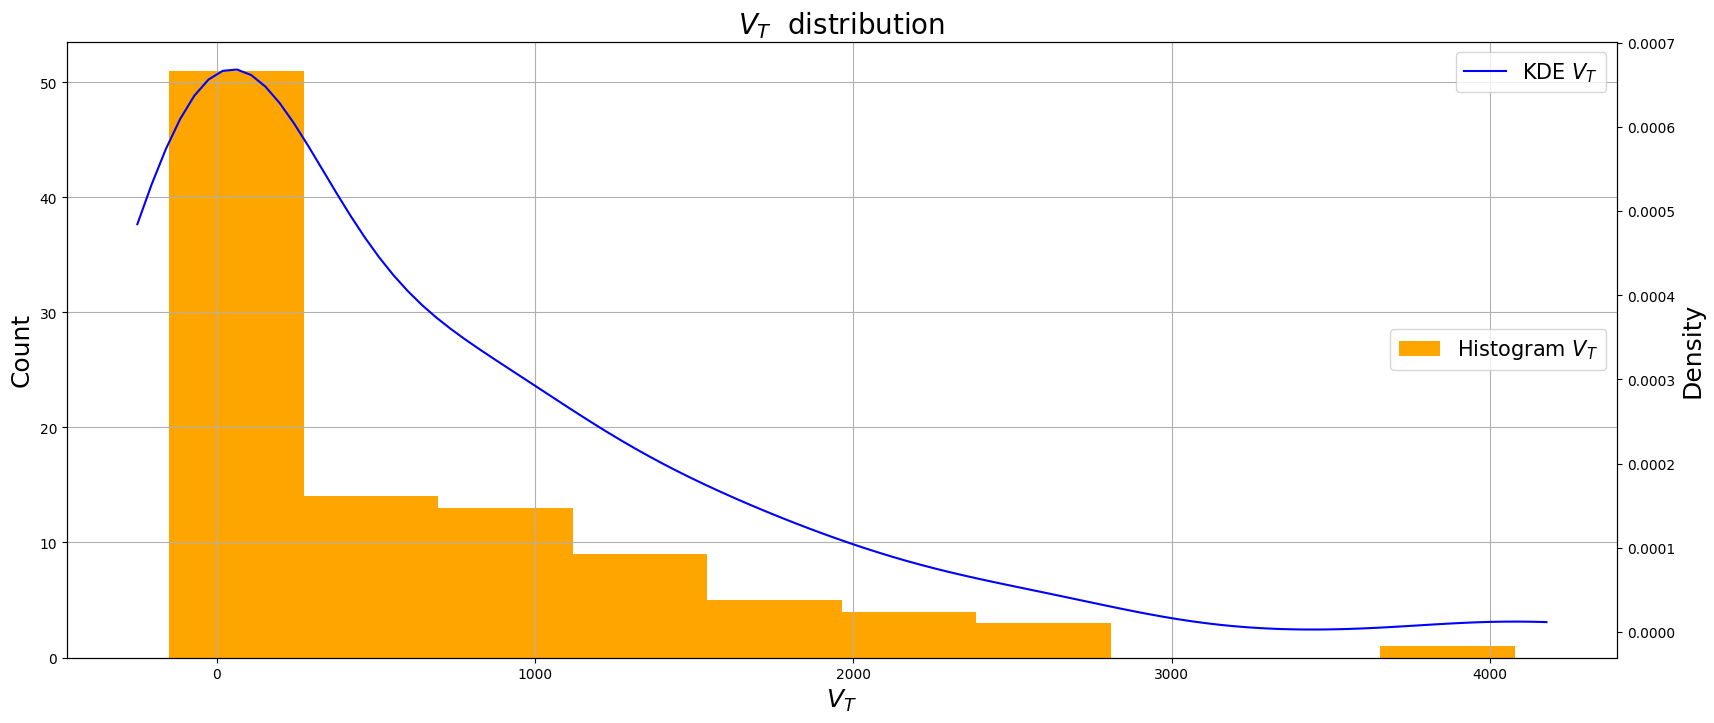

In [49]:
_, ax = plt.subplots(1, 1, figsize=(20, 8))

ax.hist(
    V_T_phi,
    color="orange",
    # alpha=0.3,
    label="Histogram $V_T$",
)
ax_l = ax.twinx()
ax_l.plot(
    np.linspace(min(V_T_phi)-100,max(V_T_phi)+100,100),
    gaussian_kde(V_T_phi, bw_method="scott").pdf( np.linspace(min(V_T_phi)-100,max(V_T_phi)+100,100)),
    color="blue",
    # alpha=0.3,
    label="KDE $V_T$",
)

ax.set_xlabel("$V_T$ ", fontsize=18)
ax.set_ylabel("Count", fontsize=18)
ax_l.set_ylabel("Density", fontsize=18)
ax.set_title(
    "$V_T$  distribution",
    fontsize=20,
)
ax.grid()
ax.legend(fontsize=15, loc="center right")
ax_l.legend(fontsize=15, loc="upper right")

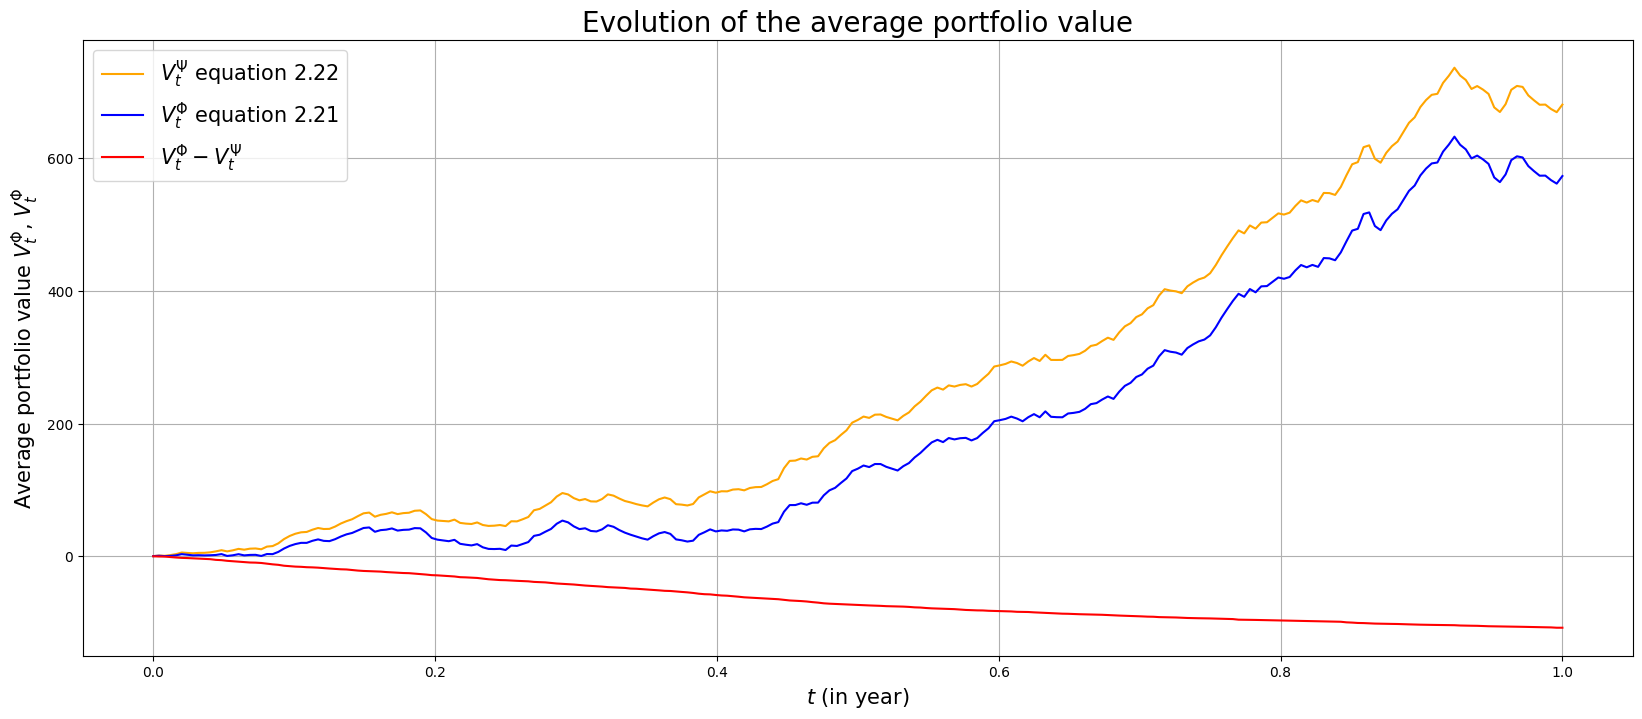

In [9]:
_, ax = plt.subplots(1, 1, figsize=(20, 8))
t = generate_t(249, 1)
ax.plot(
    t, np.mean(all_V_t_psi, axis=0), label=r"$V_t^\Psi$ equation 2.22", color="orange"
)
ax.plot(
    t,
    np.mean(all_V_t_phi, axis=0),
    # linestyle="--",
    label=r"$V_t^\Phi$ equation 2.21",
    color="blue",
)
ax.plot(
    t,
    np.mean(all_V_t_phi, axis=0) - np.mean(all_V_t_psi, axis=0),
    label=r"$V_t^\Phi-V_t^\Psi$",
    color="red",
)

ax.set_xlabel("$t$ (in year)", fontsize=15)
ax.set_ylabel(r"Average portfolio value $V_t^\Phi$, $V_t^\Phi$", fontsize=15)
ax.set_title(f"Evolution of the average portfolio value", fontsize=20)
ax.grid()
# ax_l2.legend(fontsize=15, loc="upper left")
ax.legend(fontsize=15, loc="upper left")